In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sbe_vallib import BaseValidation, BinaryScorer, BinarySampler, parse_pipeline

In [3]:
pipeline_for_coding, pipeline_for_excel, agg_config = parse_pipeline('sbe_vallib/validation/table/pipelines/Config_31.xlsx')

In [4]:
agg_config

,block_key,func
0,data_quality,sbe_vallib.validation.worst_semaphore
1,model_quality,sbe_vallib.validation.worst_semaphore
2,calibration,sbe_vallib.validation.worst_semaphore
3,specification,sbe_vallib.validation.worst_semaphore
4,stability,sbe_vallib.validation.worst_semaphore


In [5]:
from sklearn.metrics import recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


def recall_at_10(true, preds):
    return recall_score(true, preds)

def custom_test(sampler, scorer):
    pass
    

X, y = make_classification(n_samples=1000, n_classes=2,
                               n_features=5, n_informative=3, n_redundant=0,
                               random_state=0)

X = pd.DataFrame(X)
y = pd.Series(y)

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

model = LogisticRegression().fit(X_train, y_train)


sampler = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)

sampler.source_state = False

In [6]:
scorer = BinaryScorer()
scorer.score(y_test, model.predict_proba(X_test))

{'accuracy_score': 0.6666666666666666,
 'precision_score': 0.6623376623376623,
 'recall_score': 0.68,
 'f1_score': 0.6710526315789473,
 'gini': 0.5457777777777777}

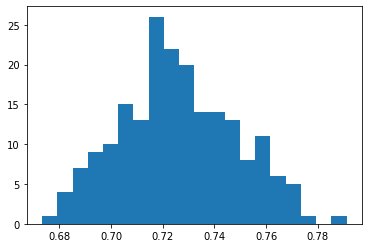

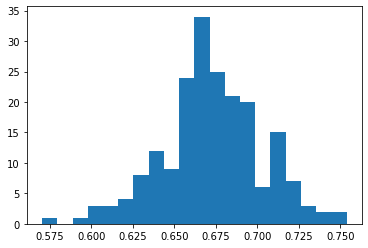

In [7]:
from sbe_vallib.validation.table.general_tests.model_quality import test_ci
import matplotlib.pyplot as plt

sampler_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)
sampler_no_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=False)

sampler_resampling = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=False)


stats = test_ci(model, sampler_resampling, scorer)
plt.hist([i['f1_score'] for i in stats['result_dict']['metrics']], bins=20)
plt.show()
stats = test_ci(model, sampler_boot, scorer)
plt.hist([i['f1_score'] for i in stats['result_dict']['metrics']], bins=20)
plt.show()

Семплер работает стабильно 

In [9]:
def custom_test(model, scorer, sampler, a = 10, **kwargs):
    metrics = []
    for i in range(a):
        sampler.set_seed(i)
        train = sampler.train
        oos = sampler.oos
        model.fit(X=train["X"], y=train["y_true"])
        y_pred = model.predict_proba(oos['X'])
        metrics.append(scorer.score(oos['y_true'], y_pred))
    
    return {
        "semaphore": "grey",
        "result_dict": {'mean_f1': np.mean([i['f1_score'] for i in metrics])},
        "result_dataframes": [pd.DataFrame(metrics)],
        "result_plots": [],
    }


custom_tests = {
    "test_0_0": {"block": "model_stability", "callable": custom_test, "params": {}},
    "test_0_0_1": {
        "block": "model_stability",
        "callable": custom_test,
        "params": {"a": 100},
    },
}


validor = BaseValidation(model, sampler, scorer, custom_tests=custom_tests)
validor.pipeline['tests']

{'train_test_independence_test': {'import_path': 'sbe_vallib.validation.table.general_tests.data_quality.test_psi_factor.test_factor_psi',
  'block_key': 'data_quality',
  'params': {},
  'informative': 1},
 'test_extremal_missing_values': {'import_path': 'sbe_vallib.validation.table.general_tests.model_quality.test_ci',
  'block_key': 'data_quality',
  'params': {'n_iter': 200, 'use_predict_proba': True},
  'informative': 0},
 'psi_factor_classes_test_oos': {'import_path': 'sbe_vallib.validation.table.general_tests.data_quality.test_psi_factor.test_factor_psi',
  'block_key': 'data_quality',
  'params': {},
  'informative': 1},
 'psi_factor_classes_test_oot': {'import_path': 'sbe_vallib.validation.table.general_tests.model_quality.test_ci',
  'block_key': 'data_quality',
  'params': {'n_iter': 200, 'use_predict_proba': True},
  'informative': 0},
 'test_key_metric': {'import_path': 'sbe_vallib.validation.table.general_tests.data_quality.test_psi_factor.test_factor_psi',
  'block_key':

In [10]:
res = validor.validate()
res.keys()

[36 36 36 36 37 36 36 36 37 36 36 36 36 36 36 36 37 36 36 13]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 37 36 36 36 36 36 37 36 36 36 37 36 36 11]
[36 36 36 36 37 36 36 36 37 36 36 36 36 36 36 36 37 36 36 13]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 37 36 36 36 36 36 37 36 36 36 37 36 36 11]
[36 36 36 36 37 36 36 36 37 36 36 36 36 36 36 36 37 36 36 13]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 16]
[36 36 36 36 36 36 37 36 36 36 36 36 37 36 36 36 37 36 36 11]
[36 36 36 36 37 36 36 36 37 36 36 36 36 36 36 36 37 36 36 13]
[36 36 3

dict_keys(['train_test_independence_test', 'test_extremal_missing_values', 'psi_factor_classes_test_oos', 'psi_factor_classes_test_oot', 'test_key_metric', 'test_confidence_inteval', 'test_presicion', 'test_recall', 'test_2_5', 'test_3_1', 'test_3_2', 'test_feature_importance', 'test_4_2', 'test_key_metric_stability', 'test_presicion_stability', 'test_recall_stability', 'test_5_4', 'test_5_6', 'test_5_7', 'test_0_0', 'test_0_0_1'])

In [11]:
res['test_4_2']['result_dataframes']

,0,1,2,3,4
psi,0.079801,0.12549,0.178843,0.174012,0.137362
feat_type,Continuous,Continuous,Continuous,Continuous,Continuous
bin_count,23,23,23,23,23
hist_train,"[0.000, 36.000, 36.000, 36.000, 36.000, 37.000...","[0.000, 36.000, 36.000, 36.000, 36.000, 36.000...","[0.000, 36.000, 36.000, 36.000, 36.000, 36.000...","[0.000, 36.000, 36.000, 36.000, 36.000, 36.000...","[1.000, 36.000, 36.000, 36.000, 36.000, 36.000..."
hist_oos,"[0.000, 15.000, 12.000, 11.000, 22.000, 17.000...","[0.000, 15.000, 4.000, 12.000, 18.000, 19.000,...","[1.000, 8.000, 13.000, 15.000, 15.000, 13.000,...","[0.000, 12.000, 7.000, 18.000, 8.000, 17.000, ...","[0.000, 26.000, 15.000, 12.000, 13.000, 20.000..."
bins,"[-inf, -4.06049, -2.28113, -1.79909, -1.54068,...","[-inf, -4.57499, -2.22574, -1.81918, -1.5337, ...","[-inf, -1.98659, -1.33592, -1.14846, -0.92486,...","[-inf, -3.11697, -1.65445, -1.31996, -1.04323,...","[-inf, -3.82494, -1.54575, -1.15434, -0.95165,..."
feature,0,1,2,3,4
semaphore,green,yellow,yellow,yellow,yellow


In [13]:
res['test_0_0_1']['result_dataframes'][0]

,accuracy_score,precision_score,recall_score,f1_score,gini
0,0.673333,0.718121,0.656442,0.685897,0.568224
1,0.666667,0.679245,0.687898,0.683544,0.524743
2,0.660000,0.662500,0.688312,0.675159,0.552660
3,0.660000,0.636364,0.680556,0.657718,0.563212
4,0.660000,0.630137,0.657143,0.643357,0.546786
...,...,...,...,...,...
95,0.666667,0.698718,0.672840,0.685535,0.551798
96,0.643333,0.627907,0.715232,0.668731,0.545491
97,0.660000,0.658228,0.684211,0.670968,0.547742
98,0.646667,0.666667,0.683230,0.674847,0.499263


In [13]:
from scipy.special import rel_entr

In [183]:
rel_entr(np.array([1, 2, 3]), np.array([1, 2, 1e-5]))

array([ 0.        ,  0.        , 37.83461326])

In [184]:
from sbe_vallib.validation.table.general_tests.data_quality.test_psi_factor import test_factor_psi

In [197]:
sampler_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                             oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)
results = test_factor_psi(sampler_boot, merge_upto_quantile=0.075)

[53 53 54 53 53 54 53 53 53 53 53 53 54  8]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]
[54 53 53 53 53 53 53 53 53 53 53 53 53 10]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]


In [198]:
results['result_dataframes']

,0,1,2,3,4
psi,0.053377,0.157847,0.076086,0.098411,0.114026
feat_type,Continuous,Continuous,Continuous,Continuous,Continuous
bin_count,17,17,17,17,17
hist_train,"[0.000, 53.000, 53.000, 54.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 54.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000..."
hist_oos,"[0.000, 26.000, 25.000, 27.000, 20.000, 17.000...","[2.000, 21.000, 18.000, 32.000, 10.000, 26.000...","[0.000, 23.000, 19.000, 22.000, 23.000, 34.000...","[0.000, 33.000, 28.000, 20.000, 22.000, 30.000...","[0.000, 34.000, 26.000, 25.000, 37.000, 11.000..."
bins,"[-inf, -4.06049, -2.00164, -1.49913, -1.04345,...","[-inf, -3.79651, -1.9582, -1.48804, -1.06203, ...","[-inf, -2.06933, -1.21815, -0.91757, -0.5612, ...","[-inf, -3.11696, -1.3541, -0.93572, -0.67664, ...","[-inf, -3.82495, -1.31814, -0.92793, -0.69203,..."
feature,0,1,2,3,4
semaphore,green,yellow,green,green,yellow


In [199]:
a, b = results['result_dataframes'][1]['hist_train'], results['result_dataframes'][1]['hist_oos']
a, b = np.array(a).astype(float), np.array(b).astype(float)


In [200]:
a / np.sum(a)

array([0.        , 0.07571429, 0.07571429, 0.07571429, 0.07571429,
       0.07571429, 0.07571429, 0.07571429, 0.07571429, 0.07571429,
       0.07571429, 0.07571429, 0.07571429, 0.07571429, 0.01571429,
       0.        ])

In [196]:
b / np.sum(b)

array([0.00666667, 0.07      , 0.04666667, 0.1       , 0.04666667,
       0.06666667, 0.07666667, 0.05      , 0.08      , 0.08666667,
       0.08333333, 0.03333333, 0.07      , 0.09666667, 0.08666667,
       0.        ])